Imports of pandas, seaborn

In [1]:
import pandas as pd
import seaborn as sns
from itertools import islice
import nltk
from nameparser.parser import HumanName
import time
import csv
import math
import matplotlib.pyplot as plt

In [2]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_palette("hls")

Download necessary ressources

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anwender\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Anwender\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Anwender\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Anwender\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

Read train dataset from csv file

In [4]:
df = pd.read_csv("../data/kaggle/train.csv")

In [5]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


Statistical analysis about length of every "text" in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

In [6]:
df["text_length"] = df["text"].apply(lambda x: math.ceil( len(str(x)) / 500))

In [ ]:
ax = sns.countplot(x=df["text_length"])
ax.locator_params(axis='x', nbins=20)
ax.set(xlabel = 'Length of article(in 500s steps)', ylabel='Number of articles', title='Distribution of (all) article length')

Statistical analysis about length of every fake news (label = 1) in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

In [ ]:
ax = sns.countplot(x=df.loc[df["label"] == 1]["text_length"])
ax.locator_params(axis='x', nbins=20)
ax.set(xlabel = 'Length of article(in 500s steps)', ylabel='Number of articles', title='Distribution of (fake-news) article length')

Statistical analysis about length of every non fake news (label = 0) in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

In [ ]:
plt.close()
ax = sns.countplot(x=df.loc[df["label"] == 0]["text_length"])
ax.locator_params(axis='x', nbins=20)
ax.set(xlabel = 'Length of article(in 500s steps)', ylabel='Number of articles', title='Distribution (non-fake-news) of article length')

Check amount of names and save result to CSV file.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

def get_human_names(text):
    tokens = nltk.tokenize.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)
    person_list = []
    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON'):
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1: #avoid grabbing lone surnames
            for part in person:
                name += part + ' '
            if name[:-1] not in person_list:
                person_list.append(name[:-1])
            name = ''
        person = []

    return len(person_list)

start_time = time.time()

df["nb_names"] = df["text"].progress_apply(lambda x: get_human_names(str(x)))

print(time.time()-start_time)

Generate graph for fake news.

In [7]:
df_wrangled = pd.read_csv("../data/transformed/wrangled.csv")

[Text(0.5, 0, 'Number of names in article'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Distribution of article name usage in fake news')]

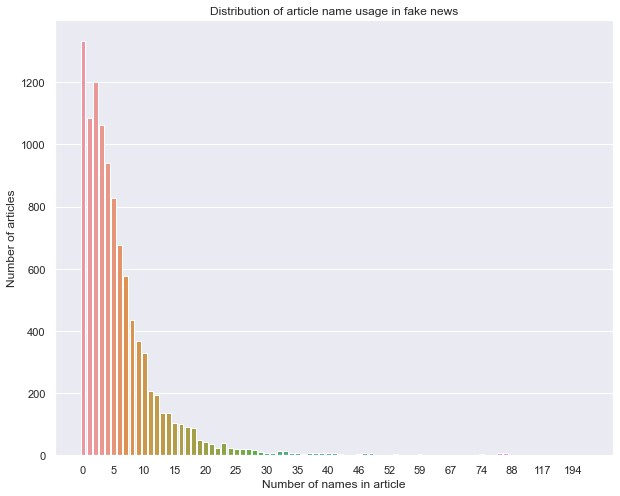

In [8]:
plt.close()
ax = sns.countplot(x=df_wrangled.loc[df_wrangled["label"] == 1]["nb_names"])
ax.locator_params(axis='x', nbins=20)
ax.set(xlabel = 'Number of names in article', ylabel='Number of articles', title='Distribution of article name usage in fake news')

Generate graph for non fake news.

[Text(0.5, 0, 'Number of names in article'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Distribution of article name usage in non-fake news')]

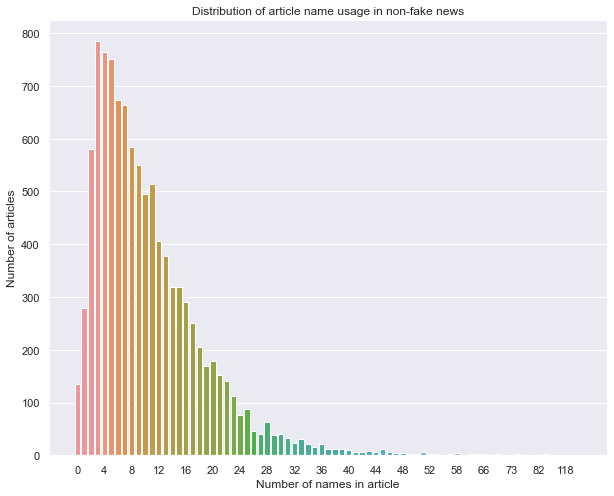

In [9]:
plt.close()
ax = sns.countplot(x=df_wrangled.loc[df_wrangled["label"] == 0]["nb_names"])
ax.locator_params(axis='x', nbins=20)
ax.set(xlabel = 'Number of names in article', ylabel='Number of articles', title='Distribution of article name usage in non-fake news')

Amount of exclamation marks in fake/ non fake news

In [ ]:
fake_exclamation_counter = 0
non_fake_exclamation_counter = 0

for index, row in df.loc[df['text'].str.contains(r'!') == True].iterrows():
    if row["label"] == 0:
        non_fake_exclamation_counter+=1
    else:
        fake_exclamation_counter+=1

print(f"Fake exclamation counter : {fake_exclamation_counter}")
print(f"Non Fake exclamation counter : {non_fake_exclamation_counter}")

In [ ]:
df["exclamation"] = df["text"].apply(lambda x: x.count(r'!'))

Check word length in articles

In [ ]:
def longer_than_(texte, nb):
    counter = 0
    for loop in str(texte).split(" "):
        if len(loop)==nb:
            counter+=1
    return counter

In [ ]:
word_length = {}
for number in range(1,20):
    word_length[number]=sum(df["text"].apply(lambda x: longer_than_(x, number)))

print(word_length)

my_df = pd.DataFrame(word_length.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = 'Number of letters', ylabel='Number of words in ', title='Amount of words with nb letters')

Specific for fake news

In [ ]:
word_length = {}
for number in range(1,20):
    word_length[number]=sum(df["text"].loc[df["label"] == 1].apply(lambda x: longer_than_(x, number)))

print(word_length)

my_df = pd.DataFrame(word_length.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = 'Number of letters', ylabel='Number of words in ', title='Amount of words with nb letters for fake news')

Specific for non fake news

In [ ]:
word_length = {}
for number in range(1,20):
    word_length[number]=sum(df["text"].loc[df["label"] == 0].apply(lambda x: longer_than_(x, number)))

print(word_length)

my_df = pd.DataFrame(word_length.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = 'Number of letters', ylabel='Number of words in ', title='Amount of words with nb letters for non fake news')

Export to file

In [ ]:
#df.to_csv("../data/transformed/wrangled.csv")